## Data preparation:

So, we load the dataset into the tensor of shape: [samples, timesteps, features]

(the number of samples or windows, the number of time steps in a window, the number of features observed at each time step)

In [1]:
dataset_name = "SelfRegulationSCP2/SelfRegulationSCP2"
magic_dim = 73728

In [2]:
datadir = "/root/data/Multivariate_ts"
epochs = 50
batch_size = 50
lr = 0.00003

In [3]:
import pandas as pd
import numpy as np
from scipy.io import arff
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn import preprocessing
from sktime.utils.load_data import load_from_tsfile_to_dataframe

from tqdm import tqdm
import os
from datetime import datetime

import matplotlib.pyplot as plt

In [4]:
# from torch.utils.tensorboard import SummaryWriter

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [6]:
def features_to_torch(X):
    X = X.applymap(np.array)
    dimensions_lst = []

    for dim in X.columns:
        dimensions_lst.append(np.dstack(list(X[dim].values))[0])

    dimensions_lst = np.array(dimensions_lst)
    X = torch.from_numpy(np.array(dimensions_lst, dtype=np.float64))
    X = X.transpose(0, 2)
    X = X.transpose(1, 2)
    X = F.normalize(X, dim=1)
    return X.float()

def answers_to_torch(y):
    le = preprocessing.LabelEncoder()
    y = le.fit_transform(y)
    y = torch.from_numpy(np.array(y, dtype=np.int32))
    y = y.long()
    return y

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt], excerpt

In [7]:
X_train, y_train = load_from_tsfile_to_dataframe(datadir + f'/{dataset_name}_TRAIN.ts')
X_test, y_test = load_from_tsfile_to_dataframe(datadir + f'/{dataset_name}_TEST.ts')

X_train = features_to_torch(X_train)
X_test = features_to_torch(X_test)

y_train = answers_to_torch(y_train)
y_test = answers_to_torch(y_test)

In [8]:
N = X_train.shape[0]
time_steps = X_train.shape[2]
dims_num = X_train.shape[1]
num_classes = len(np.unique(y_train))

print('time_steps:', time_steps)
print('train samples_num:', N)
print('dims_num:', dims_num)
print('num_classes:', num_classes)

time_steps: 1152
train samples_num: 200
dims_num: 7
num_classes: 2


## Models

In [9]:
def make_cnn(dims_num, num_classes):
    model = nn.Sequential(                                                          # [30, 4, 65]
        nn.Conv1d(in_channels=dims_num, out_channels=10, kernel_size=3, padding=1), # [30, 10, 65]
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=2),                                                # [30, 10, 32]
        nn.Flatten(),                                                               # [30, 320]
        nn.Linear(int(time_steps/2)*10, num_classes),                               # [30, 4]
        nn.Softmax()
    )
    return model

In [10]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.softmax = nn.Softmax()
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0)) # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        out = self.fc(out[:, -1, :]) # Decode the hidden state of the last time step
        return out

In [11]:
def compute_accuracy(logits, y_true, device='cuda:0'):
    y_pred = torch.argmax(logits, dim=1)
    return (y_pred == y_true.to(device)).float().mean()

In [12]:
def train(model, num_epochs, batch_size, writer=None):
    train_loss = []
    train_accuracy = []
    val_accuracy = []
    
    for epoch in tqdm(range(num_epochs), desc='train', total=num_epochs):
        train_accuracy_batch = []
        train_loss_batch = []
        model.train(True)
        for i, (x_batch, labels, _) in enumerate(iterate_minibatches(X_train, y_train, batch_size, shuffle=True)):
            x_batch = x_batch.to(device)
            labels = labels.to(device)

            predictions = model(x_batch.float())
            loss = criterion(predictions, labels.long())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            accuracy = compute_accuracy(predictions, labels, device=device)

            train_loss_batch.append(loss.item())
            train_accuracy_batch.append(accuracy.item())
            if writer:
                writer.add_scalar('train/loss', loss.item(), global_step=len(train_loss))
            
        train_accuracy_overall = np.mean(train_accuracy_batch) * 100
        train_accuracy.append(train_accuracy_overall.item())
        
        train_loss_overall = np.mean(train_loss_batch)
        train_loss.append(train_loss_overall.item())
        if writer:
            writer.add_scalar('train/accuracy', train_accuracy_overall.item(), epoch + 1)
        
        
        model.train(False)
        val_accuracy_batch = []
        for i, (x_batch, labels, _) in enumerate(iterate_minibatches(X_test, y_test, batch_size, shuffle=True)):
            x_batch = x_batch.to(device)
            labels = labels.to(device)

            predictions = model(x_batch.float())

            accuracy = compute_accuracy(predictions, labels, device=device)
            val_accuracy_batch.append(accuracy.item())

        val_accuracy_overall = np.mean(val_accuracy_batch) * 100
        val_accuracy.append(val_accuracy_overall.item())
        
    return train_accuracy_overall, train_loss_overall, train_accuracy, train_loss, val_accuracy_overall, val_accuracy

In [13]:
# %load_ext tensorboard

# logs_base_dir = "./logs"
# os.makedirs(logs_base_dir, exist_ok=True)
# %tensorboard --logdir {logs_base_dir}

In [14]:
def plot_loss_and_acc(loss, acc, val_acc, string):
    plt.figure(figsize=(18, 5))
    plt.subplot(131)
    plt.plot(loss)
    plt.grid(True)
    plt.title("Train loss " + string)
    plt.subplot(132)
    plt.plot(acc)
    plt.grid(True)
    plt.title("Train accuracy, % " + string)
    plt.subplot(133)
    plt.plot(val_acc)
    plt.grid(True)
    plt.title("Test accuracy, % " + string);

### RNN train:

In [15]:
# Hyper-parameters
sequence_length = 28
input_size = X_train.size(-1)
hidden_size = 128
num_layers = 2

In [16]:
model_rnn = RNN(input_size, hidden_size, num_layers, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_rnn.parameters(), lr=lr)

# exp_name = datetime.now().isoformat(timespec='seconds') + f'RNN'
# exp_name = str.replace(exp_name, ":", "-")
# writer = SummaryWriter(f'logs/{exp_name}')
train_accuracy_overall, train_loss_overall, train_accuracy, train_loss, val_accuracy_overall, val_accuracy = train(model_rnn, epochs, batch_size, writer=None)
train_accuracy_overall, train_loss_overall, val_accuracy_overall

train: 100%|██████████| 50/50 [00:01<00:00, 39.96it/s]


(64.99999910593033, 0.6737945526838303, 51.33333206176758)

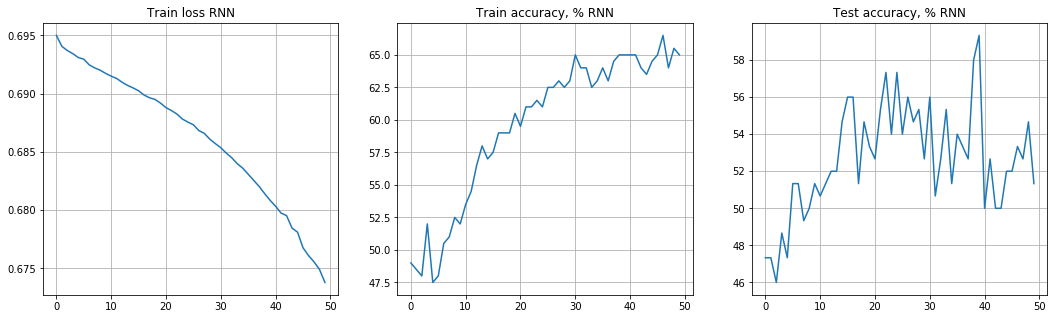

In [17]:
plot_loss_and_acc(train_loss, train_accuracy, val_accuracy, "RNN")

### CNN train

In [18]:
model_cnn = make_cnn(dims_num, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=lr)

# exp_name = datetime.now().isoformat(timespec='seconds') + f'CNN'
# exp_name = str.replace(exp_name, ":", "-")
# writer = SummaryWriter(f'logs/{exp_name}')
train_accuracy_overall, train_loss_overall, train_accuracy, train_loss, val_accuracy_overall, val_accuracy = train(model_cnn, epochs, batch_size, writer=None)
train_accuracy_overall, train_loss_overall, val_accuracy_overall

train:   0%|          | 0/50 [00:00<?, ?it/s]/opt/conda/lib/python3.6/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
train: 100%|██████████| 50/50 [00:00<00:00, 59.91it/s]


(73.99999797344208, 0.6724950969219208, 48.666665951410934)

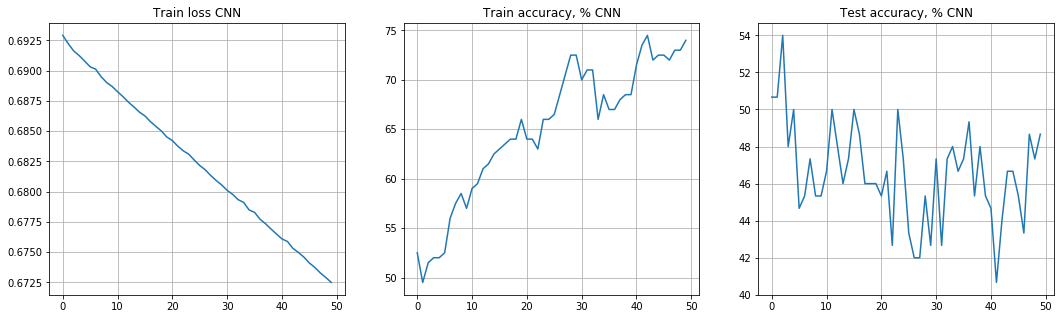

In [19]:
plot_loss_and_acc(train_loss, train_accuracy, val_accuracy, "CNN")

### ResNet

In [20]:
import torch.nn as nn
import math

__all__ = ['resnetv1','resnetv1_18']

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv1d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class Normalize(nn.Module):
    def __init__(self, power=2):
        super(Normalize, self).__init__()
        self.power = power

    def forward(self, x):
        norm = x.pow(self.power).sum(1, keepdim=True).pow(1. / self.power)
        out = x.div(norm)
        return out

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm1d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm1d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv1d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm1d(planes)
        self.conv2 = nn.Conv1d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(planes)
        self.conv3 = nn.Conv1d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm1d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, in_channel=3, width=1, num_classes=[1000]):
        self.inplanes = 16
        super(ResNet, self).__init__()
        self.headcount = len(num_classes)
        self.base = int(16 * width)
        self.features = nn.Sequential(*[                                                     # [100, 8, 18]
                            nn.Conv1d(in_channel, 16, kernel_size=3, padding=1, bias=False), # [100, 16, 36]
                            nn.BatchNorm1d(16),
                            nn.ReLU(inplace=True),
                            self._make_layer(block, self.base, layers[0]),                   # [100, 16, 36]
                            self._make_layer(block, self.base * 2, layers[1]),               # [100, 32, 36]
                            self._make_layer(block, self.base * 4, layers[2]),               # [100, 64, 36]
                            self._make_layer(block, self.base * 8, layers[3]),               # [100, 128, 36]
                            nn.AvgPool1d(2),                                                 # [100, 128, 18]
        ])
    
        if len(num_classes) == 1:
            self.top_layer = nn.Sequential(nn.Linear(magic_dim, num_classes[0]))
        else:
            for a, i in enumerate(num_classes):
                setattr(self, "top_layer%d" % a, nn.Linear(magic_dim, i))
            self.top_layer = None
        for m in self.features.modules():
            if isinstance(m, nn.Conv1d):
                n = m.kernel_size[0] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv1d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.features(x.float())
        out = out.view(out.size(0), -1)
        if self.headcount == 1:
            if self.top_layer:
                out = self.top_layer(out)
            return out
        else:
            outp = []
            for i in range(self.headcount):
                outp.append(getattr(self, "top_layer%d" % i)(out))
            return outp

def resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    return model

def resnetv1_18(num_classes=[1000]):
    """Encoder for instance discrimination and MoCo"""
    return resnet18(num_classes=num_classes)

In [21]:
hc=1       # number of heads
ncl=num_classes # number of clusters

numc = [ncl] * hc

In [ ]:
model_resnet = resnet18(num_classes=numc, in_channel=dims_num).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_resnet.parameters(), lr=lr)

exp_name = datetime.now().isoformat(timespec='seconds') + f'ResNet'
exp_name = str.replace(exp_name, ":", "-")
# writer = SummaryWriter(f'logs/{exp_name}')
train_accuracy_overall, train_loss_overall, train_accuracy, train_loss, val_accuracy_overall, val_accuracy = train(model_resnet, epochs, batch_size, writer=None)
train_accuracy_overall, val_accuracy_overall

train:  66%|██████▌   | 33/50 [00:05<00:02,  6.18it/s]

In [ ]:
print (dataset_name)
plot_loss_and_acc(train_loss, train_accuracy, val_accuracy, "ResNet")

## VGG

In [ ]:
def make_vgg_1d():
    fc_hidden_dim = 50

    model = nn.Sequential(
                nn.Conv1d(dims_num, 64, kernel_size=3, stride=1, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
                nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
                nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
                nn.Conv1d(256, 512, kernel_size=3, stride=1, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
                nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),

                nn.Flatten(),
                nn.Linear(in_features=512 * (time_steps // 2**5), out_features=fc_hidden_dim, bias=True),

                nn.ReLU(inplace=True),
                nn.Dropout(p=0.5, inplace=False),
                nn.Linear(in_features=fc_hidden_dim, out_features=fc_hidden_dim, bias=True),
                nn.ReLU(inplace=True),
                nn.Dropout(p=0.5, inplace=False),
                nn.Linear(in_features=fc_hidden_dim, out_features=num_classes, bias=True),
                nn.Softmax()
                        )
    return model

In [ ]:
model_resnet = resnet18(num_classes=numc, in_channel=dims_num).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_resnet.parameters(), lr=lr)

exp_name = datetime.now().isoformat(timespec='seconds') + f'VGG'
exp_name = str.replace(exp_name, ":", "-")
# writer = SummaryWriter(f'logs/{exp_name}')
train_accuracy_overall, train_loss_overall, train_accuracy, train_loss, val_accuracy_overall, val_accuracy = train(model_resnet, epochs, batch_size, writer=None)

train_accuracy_overall, val_accuracy_overall

In [ ]:
print (dataset_name)
plot_loss_and_acc(train_loss, train_accuracy, val_accuracy, "VGG")